## Exploratory Data Analysis (EDA)
# Introduction
**The aim of the project** is to conduct an Exploratory Data Analysis on the *weather* and *air_quality* datasets to examine them comprehensively before applying modeling and statistical analysis to predict *Daily Solar Panel Efficiency* . The analysis includes data cleaning, outlier detection and handling, correlation analysis, and feature engineering. Key findings and recommendations are highlighted to enhance the predictive power of future models.

Load the dataset and inspect its structure to understand the basic characteristics.

In [58]:
# Import needed libraries
import os
import numpy as np
import pandas as pd
from imblearn.over_sampling import SMOTENC
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import requests
import math
from scipy.stats import boxcox
import sqlite3 as sql
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold

#some color for use
GREEN = '\033[92m'
RESET = '\033[0m'

#LOAD Data

# Define the URL of the SQLite database file
weather_URL = "https://techassessment.blob.core.windows.net/aiap18-assessment-data/weather.db"
air_URL = "https://techassessment.blob.core.windows.net/aiap18-assessment-data/air_quality.db"

# Function to query the SQLite database
def query_database(path, query):
    connection = sql.connect(path) 
    df= pd.read_sql_query(query, connection)
    print(f"Database queried successfully: {path}")
    connection.close()
    return df

# Query downloaded databases
weather_data = query_database('data/weather.db',"SELECT * FROM weather")
air_data = query_database('data/air_quality.db',"SELECT * FROM air_quality")

Database queried successfully: data/weather.db
Database queried successfully: data/air_quality.db


### We should first merge the two datasets so that all available features can be used simultaneously to build machine learning models. For merging, first see the shape of data and top few rows.

In [59]:
print(f"{GREEN}First few rows of weather data: {RESET} \n")
weather_data.head()

First few rows of weather data:  



,data_ref,date,Daily Rainfall Total (mm),Highest 30 Min Rainfall (mm),Highest 60 Min Rainfall (mm),Highest 120 Min Rainfall (mm),Min Temperature (deg C),Maximum Temperature (deg C),Min Wind Speed (km/h),Max Wind Speed (km/h),Sunshine Duration (hrs),Cloud Cover (%),Wet Bulb Temperature (deg F),Relative Humidity (%),Air Pressure (hPa),Dew Point Category,Wind Direction,Daily Solar Panel Efficiency
0,4d4d20c2-0167-4bc2-a62c-4df6e11fb2ea,01/04/2014,-,2,2,2,28.4,32.4,7.5,25.9,8.07,18.0,-59.3,100.0,1006,VH,W,High
1,c9d3c825-fd94-4e61-a4bc-2cf0f2208de0,02/04/2014,0,0,0,--,28.8,32.6,--,33.1,7.57,23.0,59.2,100.0,1005,Very High,S,Medium
2,6d445ffb-d4c2-4f94-a27e-224fabe46d10,03/04/2014,0,0,0,0,29.3,--,--,43.2,6.72,16.0,59.7,98.5,1005,Low,E,Medium
3,7a404c50-710f-451a-9a42-a66bb783a3d0,04/04/2014,0,0,0,0,28.6,32.4,7.4,33.1,7.55,20.0,59.1,100.0,1011,Very High,W,Medium
4,0d3194a7-ad1a-456e-9bf8-b1bae730977b,05/04/2014,23.4,15.2,17.2,17.4,26.4,28,5.4,28.1,5.27,74.0,58.9,100.0,1012,Very High,east,Low


In [60]:
print(f"{GREEN}First few rows of air quality data: {RESET} \n")
air_data.head()

First few rows of air quality data:  



,data_ref,date,pm25_north,pm25_south,pm25_east,pm25_west,pm25_central,psi_north,psi_south,psi_east,psi_west,psi_central
0,4d4d20c2-0167-4bc2-a62c-4df6e11fb2ea,01/04/2014,20,16,18,23,19,58,56,57,66,59
1,c9d3c825-fd94-4e61-a4bc-2cf0f2208de0,02/04/2014,18,14,-,22,16,57,53,54,61,56
2,6d445ffb-d4c2-4f94-a27e-224fabe46d10,03/04/2014,12,12,10,14,10,55,53,52,59,54
3,7a404c50-710f-451a-9a42-a66bb783a3d0,04/04/2014,--,-,24,19,25,58,57,55,-,56
4,0d3194a7-ad1a-456e-9bf8-b1bae730977b,05/04/2014,18,19,21,13,17,64,64,66,-,66


In [61]:
print(f"{GREEN}Dimensions of weather data: {weather_data.shape} {RESET} ")
print(f"{GREEN}Dimensions of air quality data: {air_data.shape} {RESET} ")

Dimensions of weather data: (3517, 18)  
Dimensions of air quality data: (3875, 12)  


## MERGING

*weather* and *air_quality* data have unequal number of rows and features. The available features in these datasets also do not overlap. *air_quality* has more datapoints than *weather*. The key to merging these two dataframes is the unique identifier variable *data_ref* and *date* . I will first merge the two dataframes:

In [62]:
#merge the two datasets based on data_ref and date
merged_data = pd.merge(air_data, weather_data,on=['data_ref','date'], how='inner')

print(f"{GREEN}Dimensions of merged data: {merged_data.shape} {RESET}")


Dimensions of merged data: (4258, 28) 


# Data cleaning

## Data type

We can first look at the data types for each column to see if they are accurate. Accurate specification of data type is important to ensure they are encoded accordingly in any Machine learning models.

In [63]:
# I will frop the data_ref feature to avoid any subsequent overfitting 

if 'data_ref' in merged_data.columns:
    merged_data.drop(columns=['data_ref'], inplace=True)

merged_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4258 entries, 0 to 4257
Data columns (total 27 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   date                           4258 non-null   object 
 1   pm25_north                     4216 non-null   object 
 2   pm25_south                     4216 non-null   object 
 3   pm25_east                      4216 non-null   object 
 4   pm25_west                      4216 non-null   object 
 5   pm25_central                   4216 non-null   object 
 6   psi_north                      4216 non-null   object 
 7   psi_south                      4216 non-null   object 
 8   psi_east                       4216 non-null   object 
 9   psi_west                       4216 non-null   object 
 10  psi_central                    4216 non-null   object 
 11  Daily Rainfall Total (mm)      4258 non-null   object 
 12  Highest 30 Min Rainfall (mm)   4258 non-null   o

### Many of the variable which are non-categorical (example: Daily Rainfall Total (mm), Highest 30 Min Rainfall (mm), etc.) are saved as *object* variables. Let's first examine if these variables have any non-numerical text and remove them to convert these variables to numeric variables.

In [64]:
# Let's look at the unique values for each categorical variable.

# function to Identify categorical columns and display unique values
def categorical_uniques(df):
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns
    categorical_cols = [ s for s in categorical_cols if s not in {'data_ref','date'} ]
    # Print unique values for each categorical column
    for col in categorical_cols:
        unique_values = df[col].unique()
        print(f"Unique values in column '{col}':")
        print(unique_values)
        print()

categorical_uniques(merged_data)

Unique values in column 'pm25_north':
['20' '18' '12' '--' '22' '-' '19' '24' '25' '31' '27' '32' '23' '29' '16'
 '26' '30' '11' '15' '17' '13' '28' '10' '9' '8' '14' '21' '54' '45' '34'
 '35' '38' '37' '36' '47' '40' '33' '48' '7' '5' '6' '39' '43' '52' '49'
 '86' '42' '59' '90' '97' '63' '41' '55' '88' '199' '108' '114' '70' '115'
 '44' '105' '46' '50' '81' '71' '131' '118' '113' '78' '9.5' '83' '62'
 '61' '4' None]

Unique values in column 'pm25_south':
['16' '14' '12' '-' '19' '11' '--' '18' '20' '29' '23' '27' '21' '7' '24'
 '13' '8' '10' '17' '9' '15' '25' '6' '26' '44' '57' '49' '35' '31' '73'
 '43' '50' '32' '52' '30' '34' '28' '59' '33' '22' '5' '4' '36' '45' '40'
 '55' '90' '51' '103' '83' '69' '88' '37' '71' '235' '114' '106' '142'
 '108' '77' '140' '41' '125' '128' '39' '46' '65' '91' '53' '92' '75' '42'
 '67' '149' '135' '104' '97' '47' '11.5' '38' '3' '63' '102' '78' '60'
 None '48']

Unique values in column 'pm25_east':
['18' '-' '10' '24' '21' '11' '15' '14' '19' '17' '

### These variables contain the string '--' and '-' which is not a number (nan). We can first replace these values with nan and then convert these variables to numeric variables.

In [65]:
# Replace '--' and '-' with NaN
merged_data.replace('--', np.nan, inplace=True)
merged_data.replace('-', np.nan, inplace=True)

#Convert these variables to numeric
# Define a function to convert a column to numeric
def convert_to_numeric(column):
    # Replace '--' and other non-numeric placeholders with NaN
    column = column.replace('--', np.nan)
    # Convert to numeric, coercing errors to NaN
    return pd.to_numeric(column)

# List of variables to convert (based on looking at the data and also the description given in the assignment sheet)
columns_to_convert = ['pm25_north', 'pm25_south', 'pm25_east','pm25_west', 'pm25_central', 'psi_north', \
 'psi_south', 'psi_east', 'psi_west', 'psi_central', 'Daily Rainfall Total (mm)','Highest 30 Min Rainfall (mm)', \
  'Highest 60 Min Rainfall (mm)','Highest 120 Min Rainfall (mm)', 'Min Temperature (deg C)','Maximum Temperature (deg C)', \
   'Max Wind Speed (km/h)','Min Wind Speed (km/h)']

# Loop through the columns and apply the conversion function
for col in columns_to_convert:
    merged_data[col] = convert_to_numeric(merged_data[col])

# Examine variables again
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4258 entries, 0 to 4257
Data columns (total 27 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   date                           4258 non-null   object 
 1   pm25_north                     3813 non-null   float64
 2   pm25_south                     3794 non-null   float64
 3   pm25_east                      3798 non-null   float64
 4   pm25_west                      3813 non-null   float64
 5   pm25_central                   3806 non-null   float64
 6   psi_north                      3830 non-null   float64
 7   psi_south                      3811 non-null   float64
 8   psi_east                       3795 non-null   float64
 9   psi_west                       3818 non-null   float64
 10  psi_central                    3803 non-null   float64
 11  Daily Rainfall Total (mm)      3834 non-null   float64
 12  Highest 30 Min Rainfall (mm)   3818 non-null   f

## Missing values
### Some of these variables have missing values (i.e., total data point is lower than the total number of rows). We need to identify and handle missing values to ensure data quality. Let's look at the amount of missing values:

Percentage of missing values for each column:
 date                              0.000000
pm25_north                       10.450916
pm25_south                       10.897135
pm25_east                        10.803194
pm25_west                        10.450916
pm25_central                     10.615312
psi_north                        10.051667
psi_south                        10.497886
psi_east                         10.873650
psi_west                         10.333490
psi_central                      10.685768
Daily Rainfall Total (mm)         9.957727
Highest 30 Min Rainfall (mm)     10.333490
Highest 60 Min Rainfall (mm)     10.427431
Highest 120 Min Rainfall (mm)     9.793330
Min Temperature (deg C)           9.511508
Maximum Temperature (deg C)       9.863786
Min Wind Speed (km/h)            10.004697
Max Wind Speed (km/h)            10.333490
Sunshine Duration (hrs)           0.446219
Cloud Cover (%)                   0.446219
Wet Bulb Temperature (deg F)      0.000000
Relativ

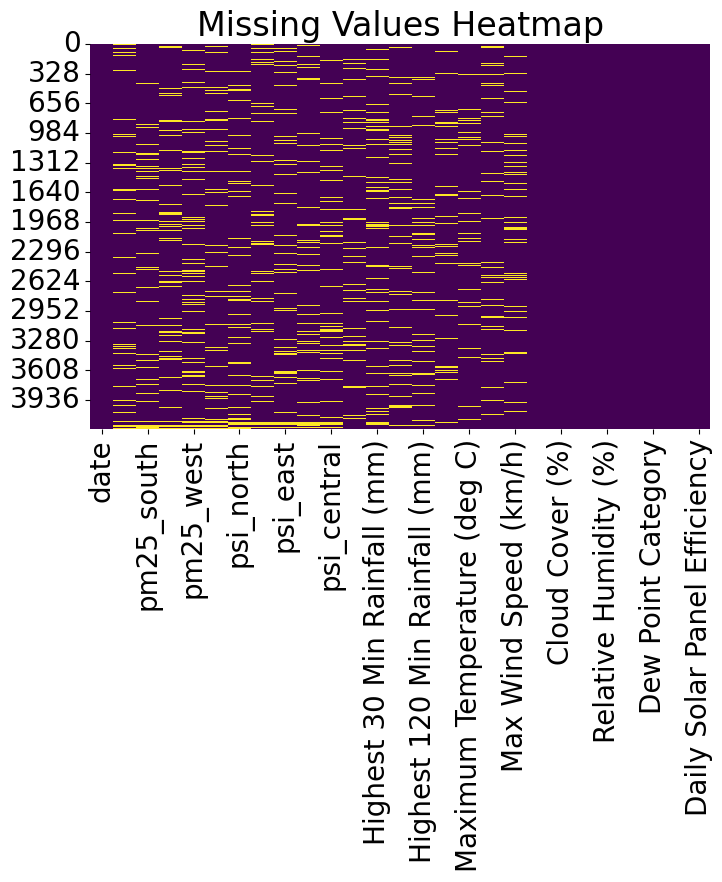

In [66]:
# define function to Check for missing values

def check_missing(df):
    missing_values = df.isnull().sum()

    # Calculate the percentage of missing values for each column
    missing_percentage = (df.isnull().sum() / df.shape[0]) * 100

    # Combine the count and percentage of missing values into one DataFrame
    missing_values_df = pd.DataFrame({
        'Missing Values Count': missing_values,
        'Missing Values Percentage': missing_percentage
    })

    # Print the percentage of missing values for each column
    print("Percentage of missing values for each column:\n", missing_percentage)

    # Visualize missing values using a heatmap
    plt.figure(figsize=(8, 5))
    sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
    plt.title('Missing Values Heatmap')
    plt.show()

check_missing(merged_data)

## Impute missing values

### Since the percentage of missing values for some of the numerical values are ~ 10% , we would lose substantial data if we were to discard them. Also replacing these values with mean/median may not be suitable given the number of outliers. We can try to impute these values using a K-nearest neighbour imputer to predict the missing values and fill them.

### Categorical variables have no missing values.

Percentage of missing values for each column:
 date                             0.0
pm25_north                       0.0
pm25_south                       0.0
pm25_east                        0.0
pm25_west                        0.0
pm25_central                     0.0
psi_north                        0.0
psi_south                        0.0
psi_east                         0.0
psi_west                         0.0
psi_central                      0.0
Daily Rainfall Total (mm)        0.0
Highest 30 Min Rainfall (mm)     0.0
Highest 60 Min Rainfall (mm)     0.0
Highest 120 Min Rainfall (mm)    0.0
Min Temperature (deg C)          0.0
Maximum Temperature (deg C)      0.0
Min Wind Speed (km/h)            0.0
Max Wind Speed (km/h)            0.0
Sunshine Duration (hrs)          0.0
Cloud Cover (%)                  0.0
Wet Bulb Temperature (deg F)     0.0
Relative Humidity (%)            0.0
Air Pressure (hPa)               0.0
Dew Point Category               0.0
Wind Direction              

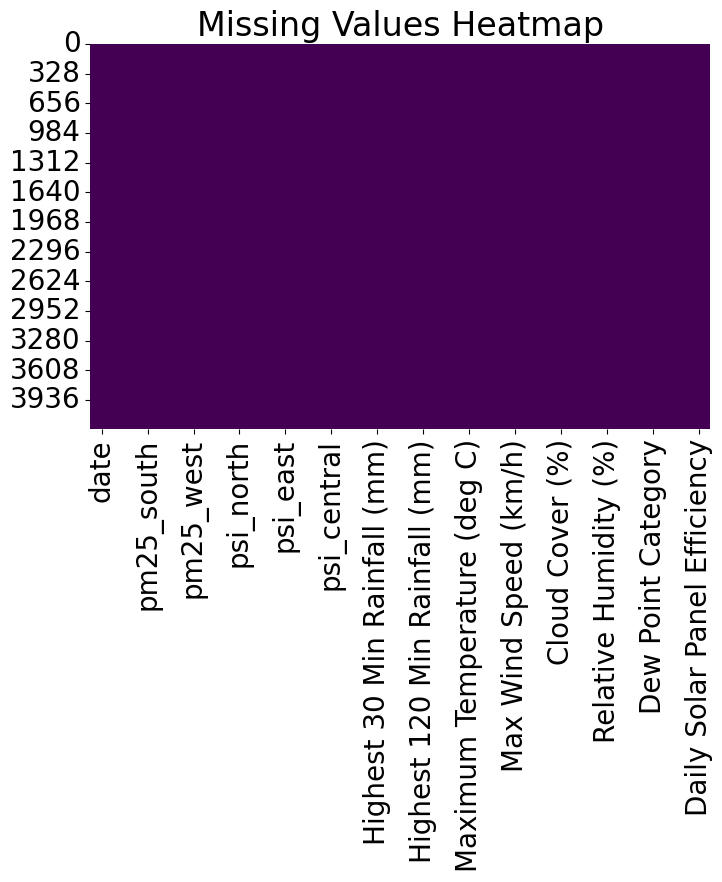

In [67]:
# Select only the numerical columns
numerical_cols = merged_data.select_dtypes(include=['float64', 'int64']).columns

# Apply KNN imputer
knn_imputer = KNNImputer(n_neighbors=5)
merged_data[numerical_cols] = knn_imputer.fit_transform(merged_data[numerical_cols])
merged_data_nomissing=merged_data
# Check for remaining missing values
check_missing(merged_data_nomissing)

## Distribution of numerical values
### The numerical variables have been specified their appropriate datatype and missing values have been imputed. Let us look at the distribution of numerical variables.


Distribution of Numerical Columns:


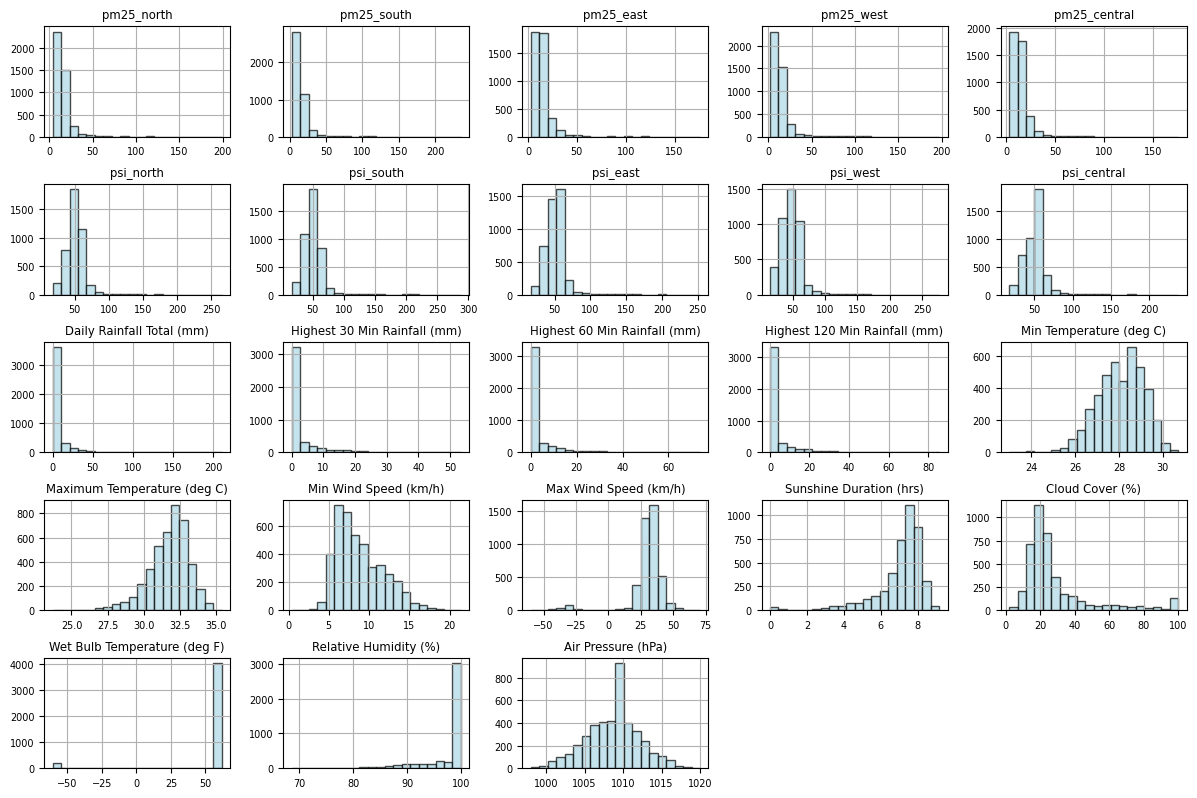

In [68]:
# Distribution of numerical columns
def plot_distributions(df):
    print("\nDistribution of Numerical Columns:")
    # Adjusting font size for all elements
    plt.rcParams.update({'font.size': 7})

    # Plotting histograms for all numerical columns in the DataFrame
    df.hist(bins=20, color='lightblue', edgecolor='black', alpha=0.7, figsize=(12, 8))

    # Adjust the layout
    plt.tight_layout()

    # Show the plot
    plt.show()

plot_distributions(merged_data_nomissing)


## Obsrvations from distribution of numerical features:
**Skewed Distributions:**
Many variables such as PM2.5 levels (pm25_north, pm25_south, pm25_east, pm25_west, pm25_central), PSI levels, rainfall metrics, Sunshine Duration, Relative Humidity (%) and Cloud Cover show skewed distributions. This indicates that most observations are clustered towards the lower end of the range, with a few high-value outliers. We will first remove outliers to see if the data conforms to normality. Many machine-learning and statistical models perform robsutly only when normality assumptions are met in the data.

The rainfall metrics ['Daily Rainfall Total (mm)', 'Highest 30 Min Rainfall (mm)', 'Highest 60 Min Rainfall (mm)', 'Highest 120 Min Rainfall (mm)'] have a significant amount of zero-valued data (i.e., absence of rain). Making a general 'Rain_Presence' variable can simplify the analysis.

**Normal-like distributions**
Min Temperature (deg C), Max Temperature (deg C), Min Wind Speed (km/h) and Air Pressure have more symmetric distributions, suggesting more evenly distributed data around the mean.

**Other notes:**
Max Wind Speed (km/h) has some negative values which are likley data-entry error. We can get the abosulte values of these inputs.
Wet Bulb Temperature (deg F) has a few negative values and most values are positve, making the variable non-normal.

In [69]:
# Make all negative values in the column "Max Wind Speed (km/h)" positive
merged_data_nomissing['Max Wind Speed (km/h)'] = merged_data_nomissing['Max Wind Speed (km/h)'].abs()

rain_columns = [ 'Daily Rainfall Total (mm)', 'Highest 30 Min Rainfall (mm)', 'Highest 60 Min Rainfall (mm)', 'Highest 120 Min Rainfall (mm)' ]

# Create a categorical variable for rain presence with 'Yes' or 'No'
merged_data_nomissing['Rain_Presence'] = np.where(merged_data_nomissing[rain_columns].sum(axis=1) > 0, 'Yes', 'No')

## Correlation between numeric variables
### Some the the variables may also crry very similar information (highly correlated), and if so, we can introduce multicollinearity in our analysis. Multicollinearity is an issue in our analysis because it leads to redundancy among features, making it difficult to determine the individual effect of each predictor on the target variable. This can result in unstable estimates of regression coefficients, inflated standard errors, and reduced model interpretability, ultimately compromising the reliability and accuracy of the model. To avoid this, we can create new variables from highly correlated variables by taking their average or sum.

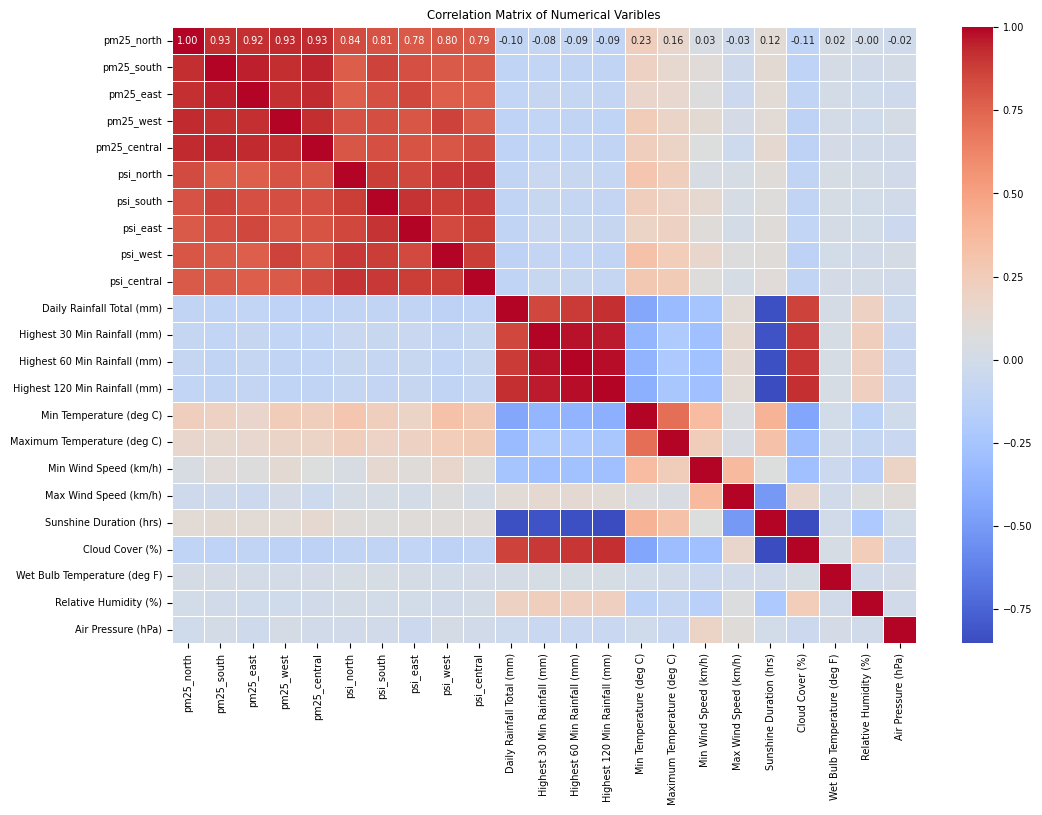

In [70]:
def correlate_numeric(df):
    # Select only the numeric columns
    numeric_columns = df.select_dtypes(include=['float64', 'int64'])

    #Calculate the correlation matrix
    correlation_matrix = numeric_columns.corr()
    

    # Create a heatmap to visualize the correlation matrix
    plt.figure(figsize=(12, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
    plt.title('Correlation Matrix of Numerical Varibles')
    plt.show()


correlate_numeric(merged_data_nomissing)


## Observations:
**High Correlations among PM2.5 Variables:** The PM2.5 variables (pm25_north, pm25_south, pm25_east, pm25_west, pm25_central) are highly correlated with each other. We can average them into a single variable.

**High Correlations among PSI Variables:** The PSI variables (psi_north, psi_south, psi_east, psi_west, psi_central) also show high correlations among themselves. We can average them into a single variable.

**Moderate Correlations among rainfall metrics:** The rainfall metrics show moderate correlations with each other as well as other variables such as *cloud cover* and *sunshine duration*. We can drop these rainfall metrics since they are highly correlated with other variables and we have bifurcated these variables into the variable *Rain_Presence*.


## Create composite variables from highly correlated variables

In [71]:
# Create a composite variable by averaging the PM2.5 variables
merged_data_nomissing['Average_PM25'] = merged_data_nomissing[['pm25_north', 'pm25_south', 'pm25_east', 'pm25_west', 'pm25_central']].mean(axis=1)
merged_data_nomissing['Average_PSI'] = merged_data_nomissing[['psi_north', 'psi_south', 'psi_east', 'psi_west', 'psi_central']].mean(axis=1)

## Drop the original variables

In [72]:
pm25_columns_to_drop = ['pm25_north', 'pm25_south', 'pm25_east', 'pm25_west', 'pm25_central']
psi_columns_to_drop = ['psi_north', 'psi_south', 'psi_east', 'psi_west', 'psi_central']
rain_columns_to_drop = ['Daily Rainfall Total (mm)', 'Highest 30 Min Rainfall (mm)', 'Highest 60 Min Rainfall (mm)', 'Highest 120 Min Rainfall (mm)']

columns_to_drop = pm25_columns_to_drop + psi_columns_to_drop + rain_columns_to_drop

# Drop the columns if they exist in the DataFrame
for col in columns_to_drop:
    if col in merged_data_nomissing.columns:
        merged_data_nomissing.drop(columns=[col], inplace=True)


## Now Remove outliers based on Inter Quartile Range (IQR)

### Outlier removal is important in building machine learning models because outliers can distort and skew the training data, leading to poor model performance and inaccurate predictions. By removing outliers, the model can learn the true underlying patterns of the data, resulting in improved accuracy and robustness. The Inter Quartile Range (IQR) method is effective for outlier removal because it is based on the middle 50% of the data, making it less sensitive to extreme values and applicable to various data distributions. Additionally, IQR is simple to calculate and understand, providing a straightforward way to enhance the quality of the dataset used for model training.

Percentage of data removed from Min Temperature (deg C): 0.94%
Percentage of data removed from Maximum Temperature (deg C): 2.75%
Percentage of data removed from Min Wind Speed (km/h): 0.54%
Percentage of data removed from Max Wind Speed (km/h): 2.84%
Percentage of data removed from Sunshine Duration (hrs): 7.80%
Percentage of data removed from Cloud Cover (%): 6.27%
Percentage of data removed from Wet Bulb Temperature (deg F): 6.13%
Percentage of data removed from Relative Humidity (%): 9.61%
Percentage of data removed from Air Pressure (hPa): 0.24%
Percentage of data removed from Average_PM25: 5.86%
Percentage of data removed from Average_PSI: 0.26%

Distribution of Numerical Columns:


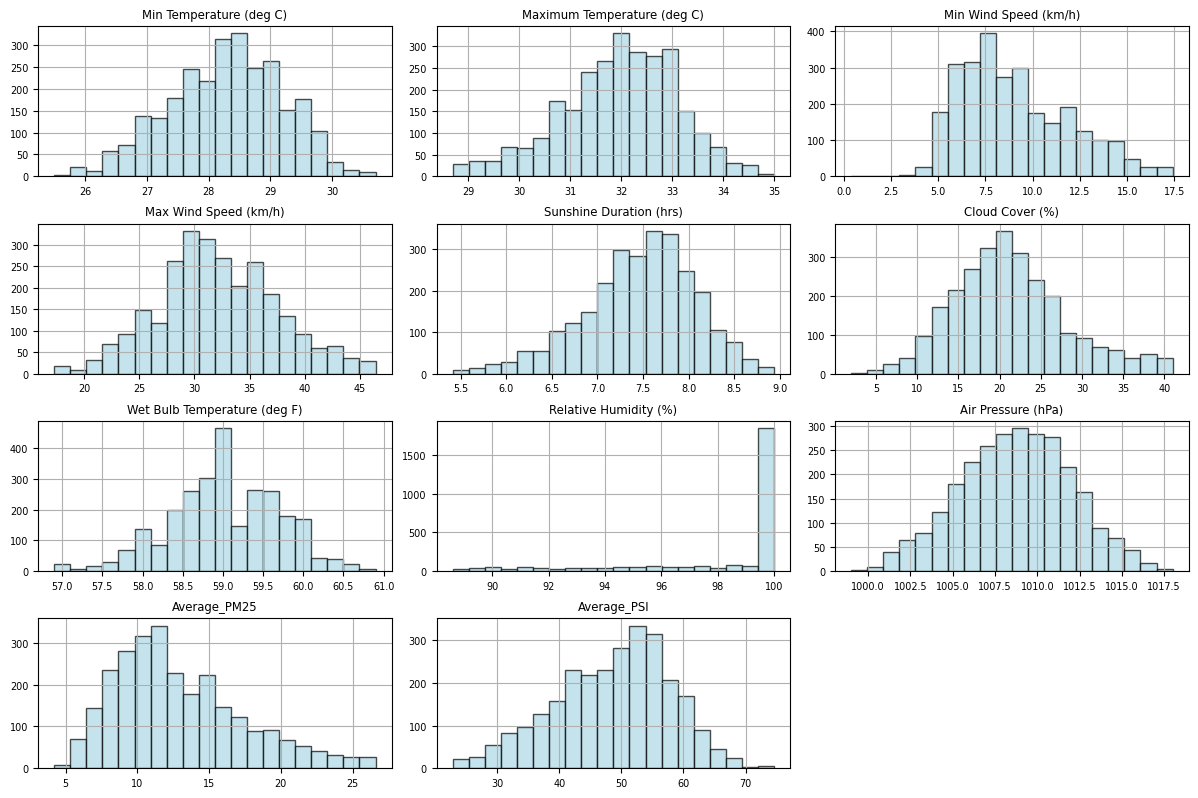

In [73]:
def remove_outliers_iqr(df):

    # Select only the numerical columns
    numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns
    
    original_row_count = df.shape[0]
    
    # Dictionary to store percentage of data removed for each column
    removed_data_percentage = {}
    
    # Remove outliers for each numerical column
    for column in numerical_cols:
        original_col_count = df[column].notna().sum()
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
        new_col_count = df[column].notna().sum()
        removed_data_percentage[column] = ((original_col_count - new_col_count) / original_col_count) * 100
    
    # Print the percentage of data removed for each variable
    for column, percentage in removed_data_percentage.items():
        print(f"Percentage of data removed from {column}: {percentage:.2f}%")
    
    return df

merged_data_nooutliers=remove_outliers_iqr(merged_data_nomissing)

# now examine the correlation again
plot_distributions(merged_data_nooutliers)
#correlate_numeric(merged_data_nooutliers)

### All variables except *Relative Humidity* resemble a normal distribution. We can try to apply a log transformation to see if it makes the variable less skewed.

Distribution of Log-transformed Relative Humidity (%)


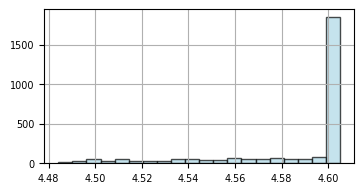

In [74]:
# Apply log transformation
merged_data_nooutliers['Log_Relative_Humidity'] = np.log(merged_data_nooutliers['Relative Humidity (%)'])
# Plot the variable
print("Distribution of Log-transformed Relative Humidity (%)")
merged_data_nooutliers['Log_Relative_Humidity'].hist(bins=20, color='lightblue', edgecolor='black', alpha=0.7, figsize=(4, 2))
plt.show()

In [75]:
# Since the Log-transforming did not significantly reduce the skewness of Relative Humidity (%), 
# now delete the original variable
if 'Log_Relative_Humidity' in merged_data_nooutliers.columns:
     merged_data_nooutliers.drop(columns=['Log_Relative_Humidity'], inplace=True)

if 'Relative Humidity (%)' in merged_data_nooutliers.columns:
    # we can bifurcate and create a binary variable for relative humidity saturation
    merged_data_nooutliers['RH_Saturation'] = np.where(merged_data_nooutliers['Relative Humidity (%)'] >= 100, 'Yes', 'No')

# now delete the original variable
if 'Relative Humidity (%)' in merged_data_nooutliers.columns:
     merged_data_nooutliers.drop(columns=['Relative Humidity (%)'], inplace=True)

## Now re-examine the distribution and correlation of numeric variables:


Distribution of Numerical Columns:


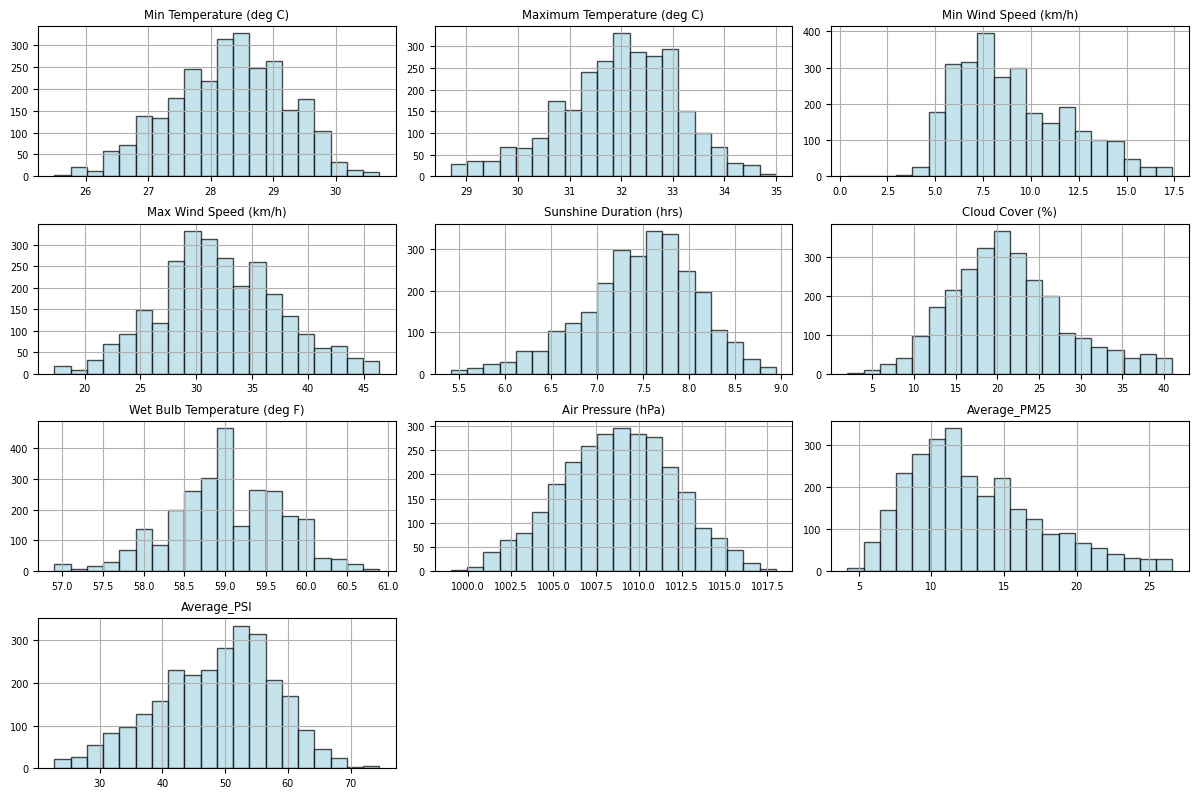

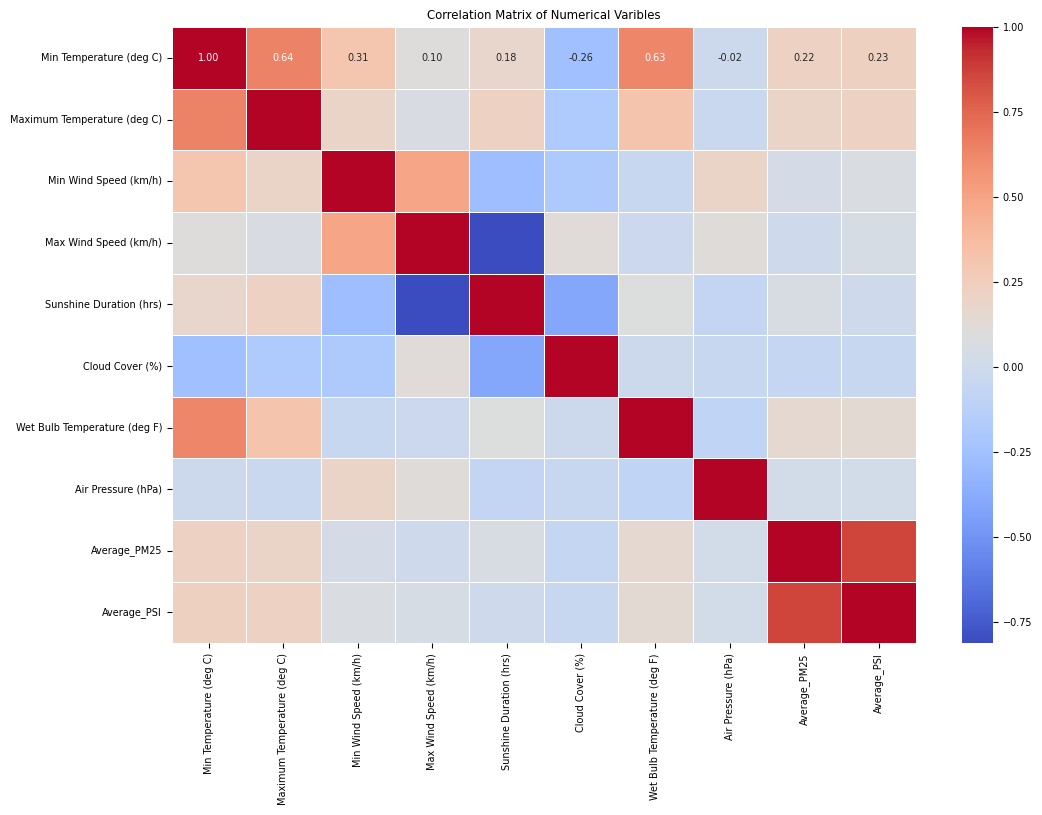

In [76]:
plot_distributions(merged_data_nooutliers)
correlate_numeric(merged_data_nooutliers)

 The numerical variables are now assigned their correct datatype, missing values imputed, outlier removed and transformed into composite varibles if they were highly correlated. All numeric variables approximately resemble normal distributions.

# Clean categorical variables

## Feature enginerring

### We can first perform feature engineering to get the month, year and day of week from the date. The month, year and day of the week may be be more informative (e.g. seasonal information) in predicting the outcome than date, which is an arbitrary value.

In [77]:
if 'date' in merged_data_nooutliers.columns:
    merged_data_nooutliers['date'] = pd.to_datetime(merged_data_nooutliers['date'], format='%d/%m/%Y')

    # Extract features from the 'date' column
    merged_data_nooutliers['month'] = merged_data_nooutliers['date'].dt.month
    merged_data_nooutliers['day_of_week'] = merged_data_nooutliers['date'].dt.day_name()
    merged_data_nooutliers['year'] = merged_data_nooutliers['date'].dt.year
    merged_data_nooutliers = merged_data_nooutliers.drop(columns=["date"])


categorical_uniques(merged_data_nooutliers)
#

Unique values in column 'Dew Point Category':
['Very High' 'Low' 'High' 'Moderate' 'Extreme' 'Very Low' 'very low' 'LOW'
 'VERY HIGH' 'High Level' 'VH' 'very high' 'HIGH' 'H' 'M' 'VL' 'high'
 'VERY LOW' 'MODERATE' 'Minimal' 'Normal' 'Below Average' 'low' 'L']

Unique values in column 'Wind Direction':
['S' 'E' 'W' 'NW' 'NE' 'SE' 'Southward' 'W.' 'SW' 'Northward' 'N'
 'NORTHEAST' 'southeast' 'SOUTHEAST' 'NORTH' 'NE.' 'SE.' 'NORTHWEST' 'SW.'
 'northwest' 'west' 'S.' 'northeast' 'NW.' 'WEST' 'E.' 'N.' 'south' 'east'
 'north' 'EAST' 'SOUTH']

Unique values in column 'Daily Solar Panel Efficiency':
['Medium' 'Low' 'High']

Unique values in column 'Rain_Presence':
['No' 'Yes']

Unique values in column 'RH_Saturation':
['Yes' 'No']

Unique values in column 'day_of_week':
['Wednesday' 'Thursday' 'Friday' 'Monday' 'Tuesday' 'Saturday' 'Sunday']



## Standardize inputs

### In the variables *Dew Point Category* and *Wind Direction*, the values are not consistently indicative of specific categories. For example, "Very High" is input as "VH" or "very high" in  *Dew Point Category*. Similarly, 'NW' is input as 'northwest', 'NORTHWEST', etc. To ensure the correct number of unique values (i.e., levels) for each categorical variable, we have to make these values consistent.

In [78]:
# Convert all values to lowercase
merged_data_nooutliers['Dew Point Category'] = merged_data_nooutliers['Dew Point Category'].str.lower()
merged_data_nooutliers['Wind Direction'] = merged_data_nooutliers['Wind Direction'].str.lower()

# Define a mapping dictionary

mapping1 = {
    'very high': 'VH',
    'vh': 'VH',
    'high': 'H',
    'high level': 'H',
    'h': 'H',
    'moderate': 'M',
    'm': 'M',
    'low': 'L',
    'l': 'L',
    'vl': 'VL',
    'very low': 'VL',
    'minimal': 'L',
    'below average': 'L',
    'extreme': 'VH',
    'normal': 'M' }


# Replace values using the mapping
merged_data_nooutliers['Dew Point Category'] = merged_data_nooutliers['Dew Point Category'].map(mapping1).fillna(merged_data_nooutliers['Dew Point Category'])

#Do the same for Wind Direction
mapping2 = {
    'w': 'West',
    'west': 'West',
    'w.': 'West',
    'nw': 'Northwest',
    'northwest': 'Northwest',
    'nw.': 'Northwest',
    'n': 'North',
    'northward': 'North',
    'north': 'North',
    'n.': 'North',
    'northeast': 'Northeast',
    'ne': 'Northeast',
    'northeast': 'Northeast',
    'ne.': 'Northeast',
    'se': 'Southeast',
    'southeast': 'Southeast',
    'se.': 'Southeast',
    's': 'South',
    'southward': 'South',
    'south': 'South',
    's.': 'South',
    'e': 'East',
    'east': 'East',
    'e.': 'East',
    'e': 'East',
    'southeast': 'Southeast',
    'southwest': 'Southwest',
    'sw': 'Southwest',
    'sw.': 'Southwest' }

# Replace values using the mapping
merged_data_nooutliers['Wind Direction'] = merged_data_nooutliers['Wind Direction'].map(mapping2).fillna(merged_data_nooutliers['Wind Direction'])

#Now look at the unique values again
categorical_uniques(merged_data_nooutliers)

Unique values in column 'Dew Point Category':
['VH' 'L' 'H' 'M' 'VL']

Unique values in column 'Wind Direction':
['South' 'East' 'West' 'Northwest' 'Northeast' 'Southeast' 'Southwest'
 'North']

Unique values in column 'Daily Solar Panel Efficiency':
['Medium' 'Low' 'High']

Unique values in column 'Rain_Presence':
['No' 'Yes']

Unique values in column 'RH_Saturation':
['Yes' 'No']

Unique values in column 'day_of_week':
['Wednesday' 'Thursday' 'Friday' 'Monday' 'Tuesday' 'Saturday' 'Sunday']



# Remove duplicates
Now remove any duplicates in the data as they are redundant and can lead to overfitting.

In [79]:
# check duplicates and remove 
print("Number of duplicates:", merged_data_nooutliers.duplicated().sum())

merged_data_nooutliers = merged_data_nooutliers[~merged_data_nooutliers.duplicated()]
print("Removed duplicates. Remaining duplicates:", merged_data_nooutliers.duplicated().sum())

Number of duplicates: 666
Removed duplicates. Remaining duplicates: 0


## Let us look at the frequency distribution of categorical features
### This will help us identify any unbalnced features, which can hap=mper model performance.

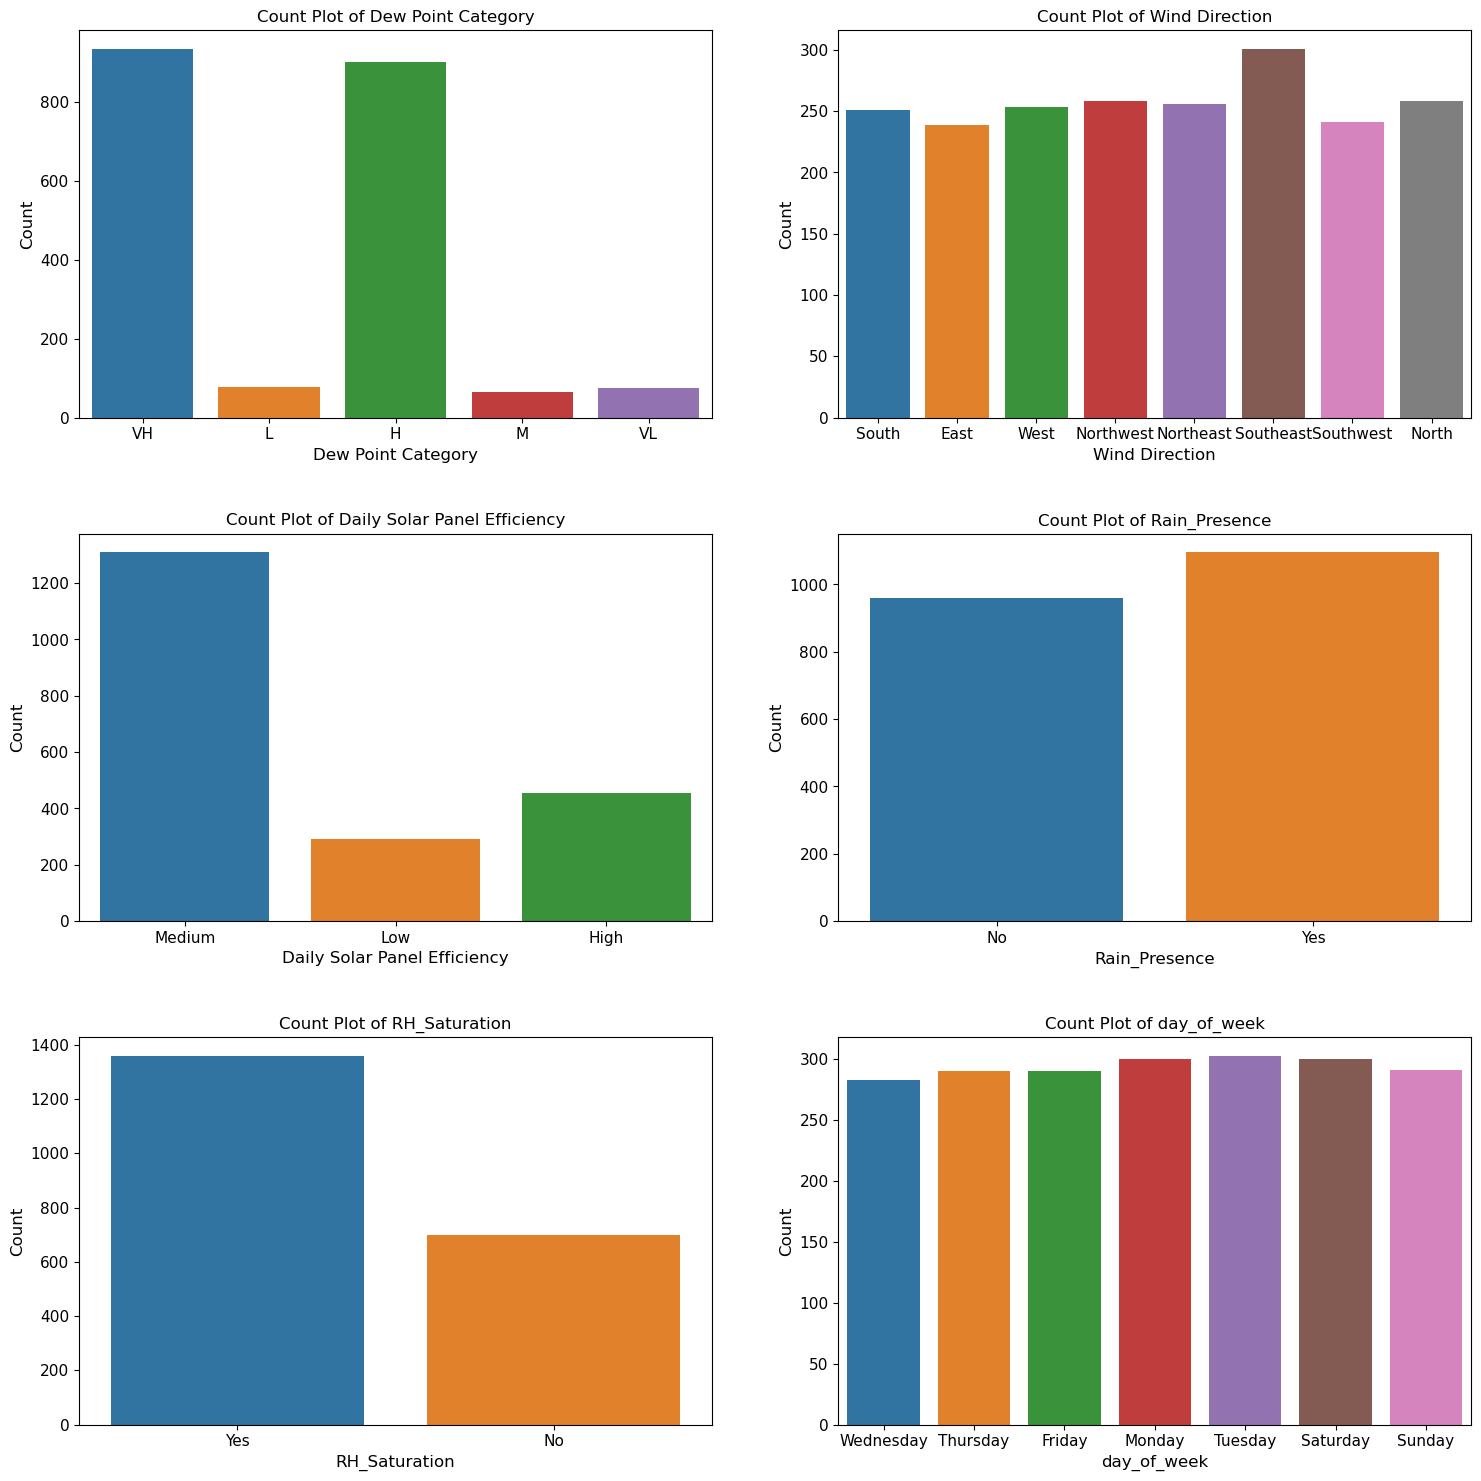

In [80]:
def plot_categorical_distributions(df):
    # Get the categorical columns
    categorical_columns = df.select_dtypes(include=['object', 'category']).columns

    # Determine the number of rows needed (2 plots per row)
    num_rows = (len(categorical_columns) + 1) // 2

    # Create subplots
    fig, axes = plt.subplots(num_rows, 2, figsize=(15, 5 * num_rows))
    axes = axes.flatten()

    # Iterate over categorical columns and generate count plots
    for i, col in enumerate(categorical_columns):
        sns.countplot(x=df[col], ax=axes[i])
        axes[i].set_title(f'Count Plot of {col}', fontsize=12)
        axes[i].set_xlabel(col, fontsize=12)
        axes[i].set_ylabel('Count', fontsize=12)
        axes[i].tick_params(axis='both', which='major', labelsize=11)

    # Remove any unused subplots
    for ax in axes[len(categorical_columns):]:
        fig.delaxes(ax)
        
    # Adjust layout for better spacing
    plt.tight_layout(pad=2.0)
    plt.subplots_adjust(hspace=0.3, wspace=0.2)


plot_categorical_distributions(merged_data_nooutliers)


## Obsrvations from distribution of categorical features:

**Dew Point Category:** The 'Dew Point Category' has an uneven distribution with 'H' (High) being the most frequent category, followed by 'VH' (Very High), and 'L' (Low). 'M' (Medium) and 'VL' (Very Low) are the least frequent. As the frequncy of all levels except 'VH' and 'H' is very rare, we will first combine these rare categories to 'M_below'. We will also choose prediction models that are more robust to imbalanced datasets (such as Decision Trees, Random Forests) or that have the ability to adjust the class weights (such as SVM and Logistic Regression).

For model performance, we will also use appropriate evaluation metrics that consider the imbalance, such as Precision, Recall, F1-score, and AUC-ROC.

**Wind Direction:**The 'Wind Direction' variable has a fairly balanced distribution across all directions with slight variations. No single direction is overly dominant.

**Daily Solar Panel Efficiency:** 'Daily Solar Panel Efficiency' shows a skewed distribution with 'Medium' being the most frequent, followed by 'High' and 'Low'. We will oversample to increase the number of samples in the minority classes (low,high) using (SMOTENC: Synthetic Minority Over-sampling Technique for Nominal and Continuous).

**Rain Presence:** The 'Rain Presence' variable is fairly balanced between 'No' and 'Yes', with a slight predominance of 'Yes'.

**RH Saturation:** The 'RH Saturation' variable shows that 'Yes' (relative humidity saturation) is more common than 'No'.

**Day of the Week:** The 'day_of_week' , month and year variables shows a balanced distribution across all days, with no significant variations.



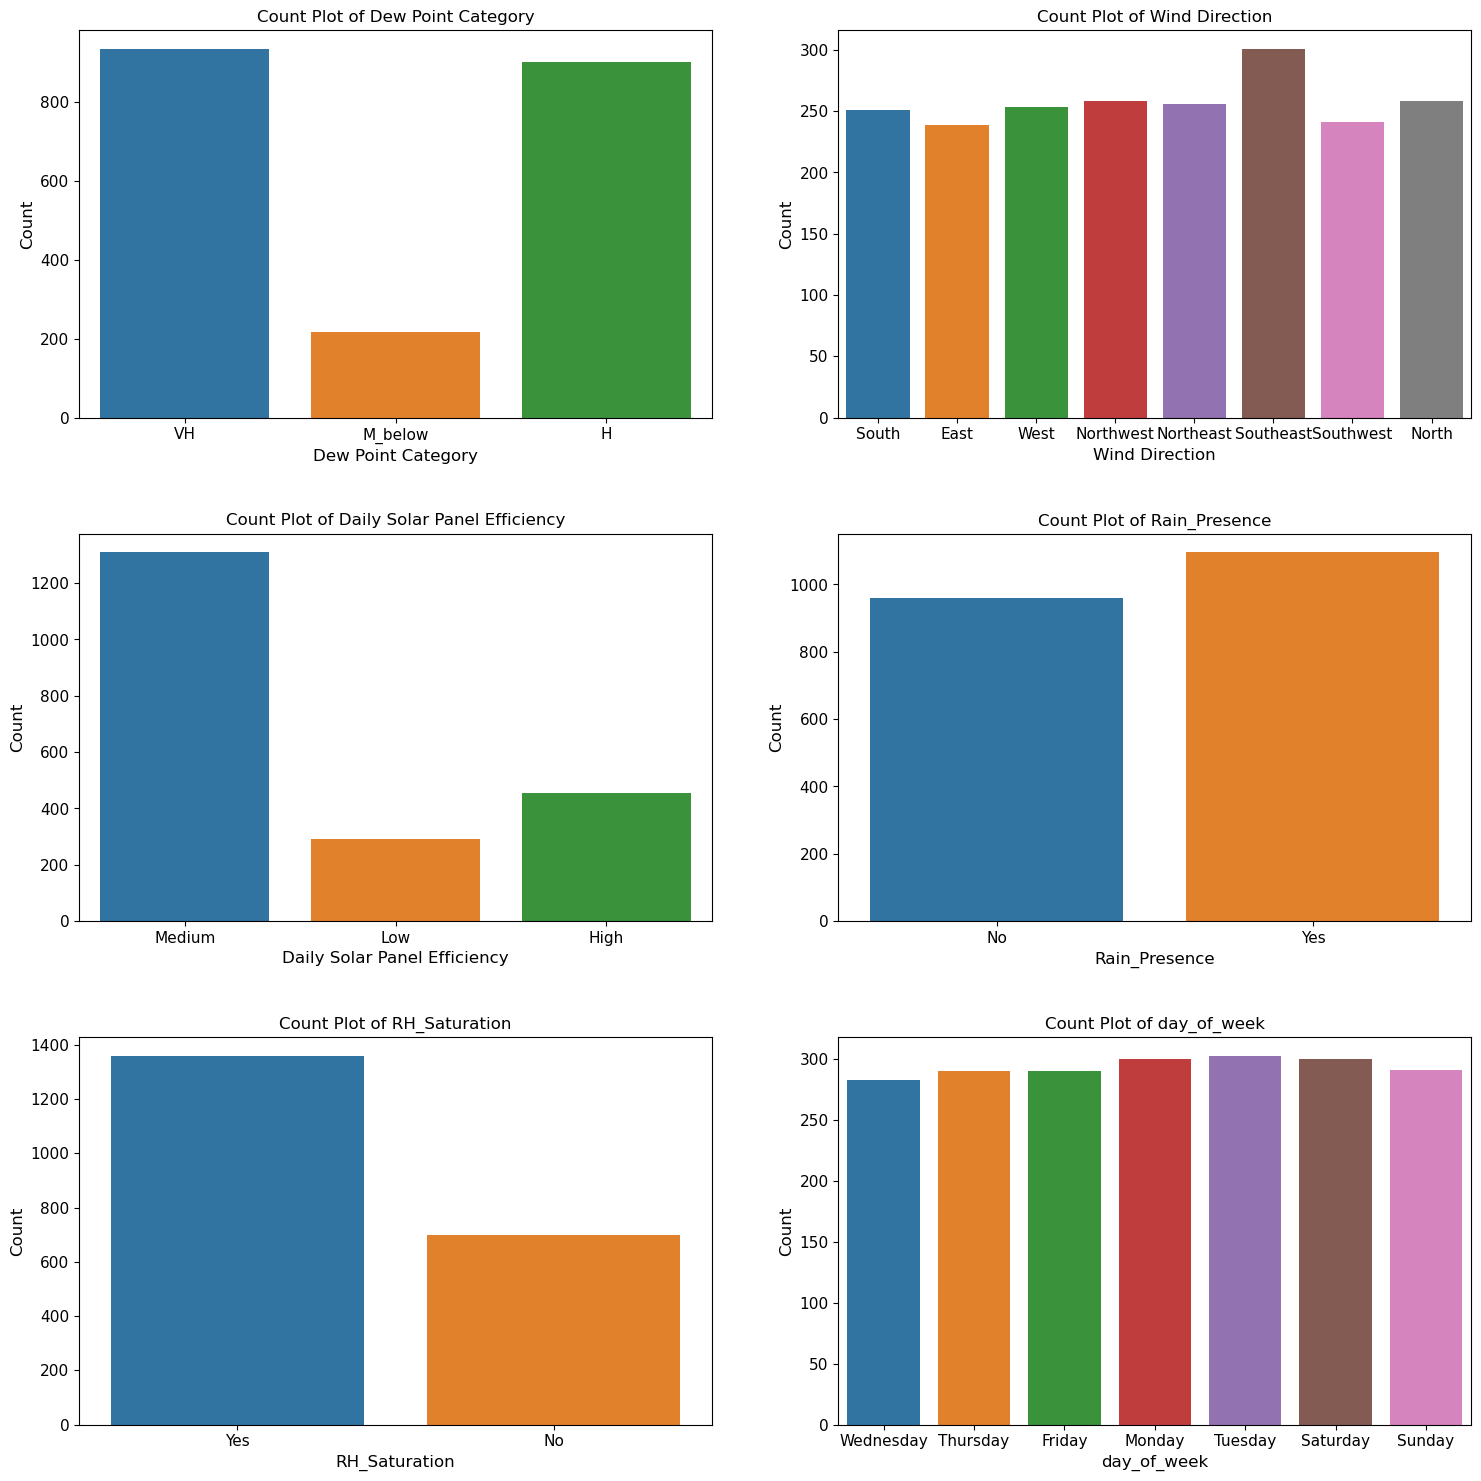

In [81]:
def combine_rare_categories(df, col, threshold=0.05):
    """Combine rare categories in a column."""
    value_counts = df[col].value_counts(normalize=True)
    rare_categories = value_counts[value_counts < threshold].index
    df[col] = df[col].apply(lambda x: 'M_below' if x in rare_categories else x)
    return df

# Combine rare categories in "Dew Point Category" 
merged_data_nooutliers = combine_rare_categories(merged_data_nooutliers, 'Dew Point Category', threshold=0.05)

plot_categorical_distributions(merged_data_nooutliers)


### We will now upsample the minority classed of the currently unbalanced target variable for better model performance. Following upsampling using SMOTENC, I will re-check if the introduction of upsampling preserved the distribution of categorical values (which is imporant to maintain the given structure of the dataset).

In [82]:
## Define a function to run SMOTENC to upsample the target variable
def apply_SMOTENC(df,target_col):
    
    cat_features = df.select_dtypes(include=['object', 'category']).columns.tolist()

    # remove the target column from in cat_features
    if target_col in cat_features:
        cat_features.remove(target_col)

    # get categorical feature indices
    categorical_feature_indices = [df.columns.get_loc(col) for col in cat_features]
 
    # Define the features and target for SMOTENC
    X = df.drop(columns=[target_col])
    y = df[target_col]

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

    # Recalculate categorical feature indices after splitting
    categorical_feature_indices = [X_train.columns.get_loc(col) for col in cat_features]

    # Initialize SMOTENC
    smote_nc = SMOTENC(categorical_features=categorical_feature_indices, random_state=42)

    # Apply SMOTENC to the training data
    X_train_resampled, y_train_resampled = smote_nc.fit_resample(X_train, y_train)

    # Combine the resampled features and target into a single dataframe
    resampled_df = pd.concat([pd.DataFrame(X_train_resampled, columns=X_train.columns),
            pd.Series(y_train_resampled, name=target_col)], axis=1)
    
    return resampled_df

target_col = 'Daily Solar Panel Efficiency'

merged_upsampled = apply_SMOTENC(merged_data_nooutliers,target_col)

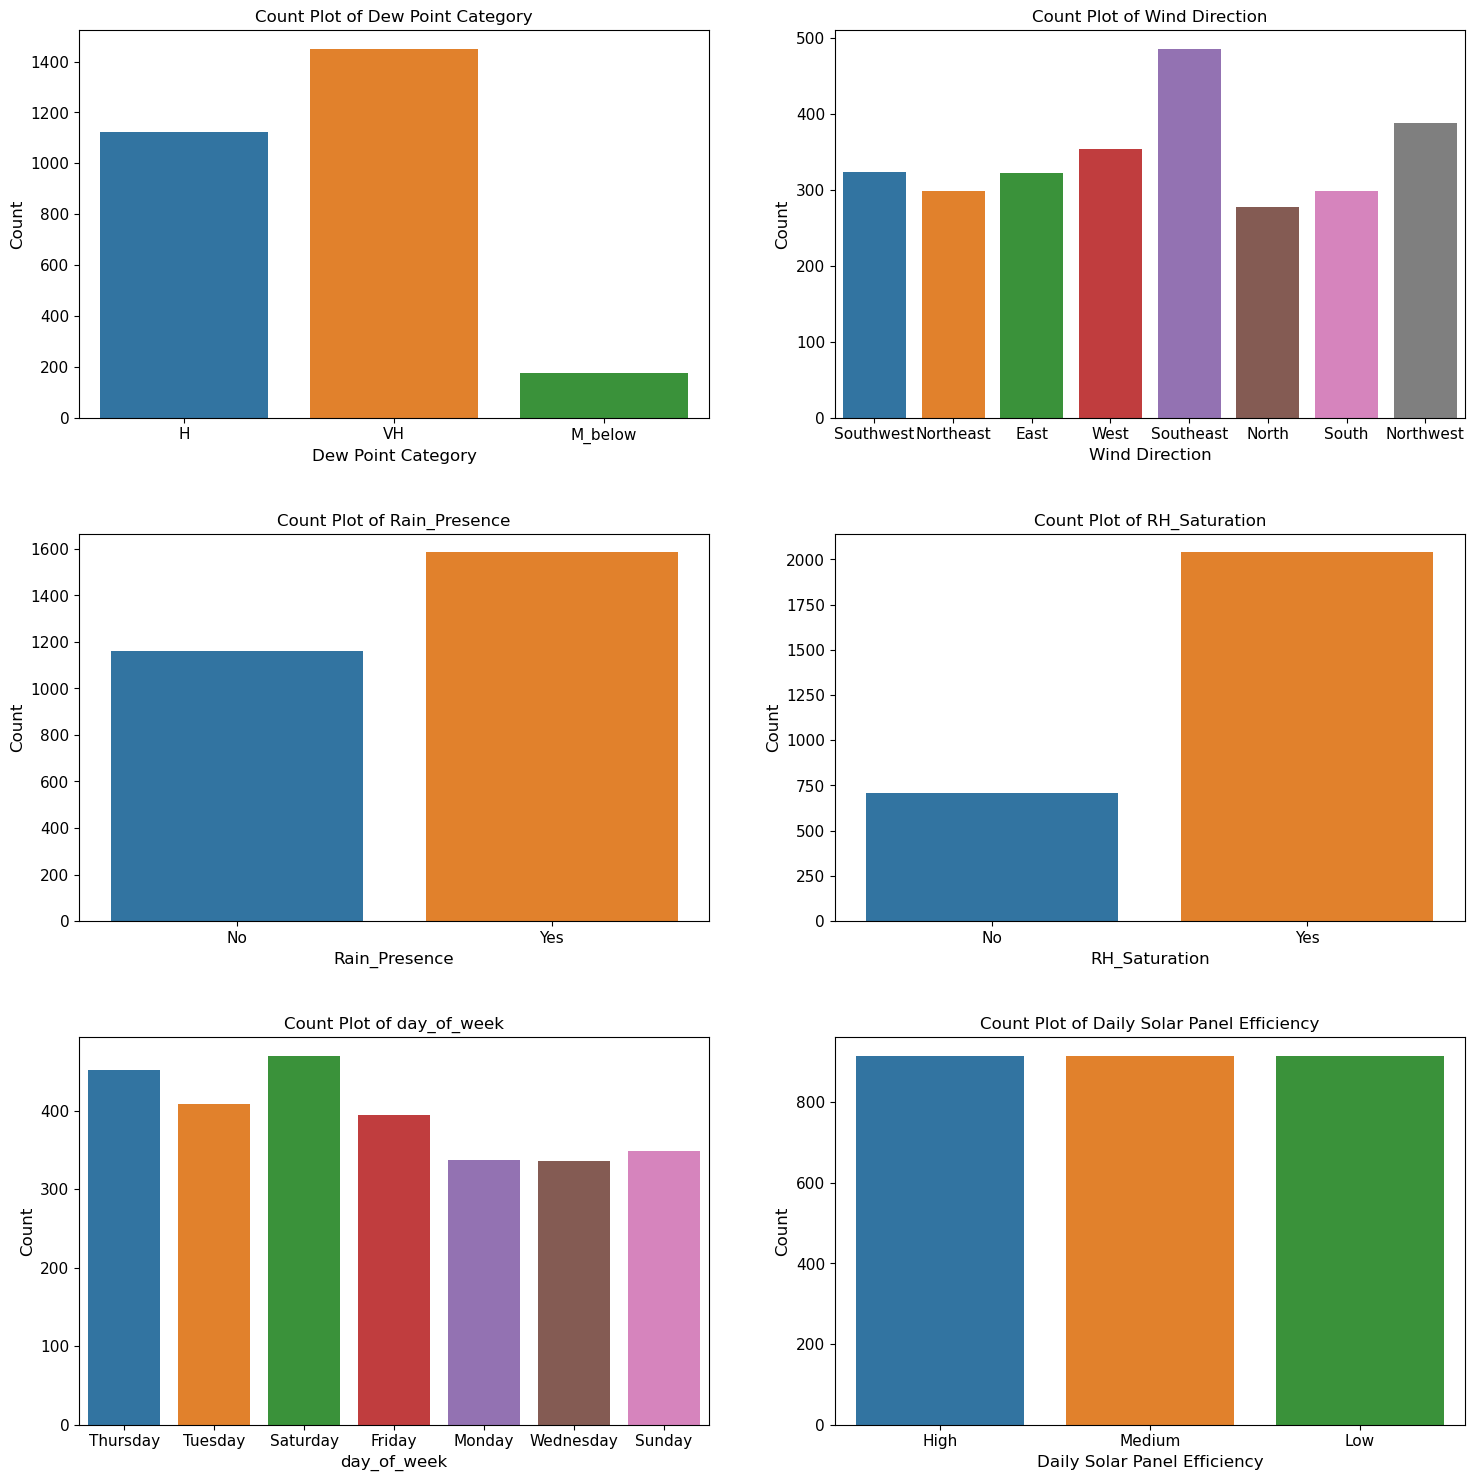

In [83]:
## Check to see if this oversampling of the target variable significantly changes the distribution of other vairables:
plot_categorical_distributions(merged_upsampled)

### The distribution of categorical values are similar after upsampling.


## Exploratory data analysis: Bivariate Analysis

### A key prediction that can be possibly made from this dataset is the target variable **Daily Solar Panel Efficiency**

**Target variable as a function of numeric variables**:
To examine this possibility, first let us visually look at the distribution of the numerical variables as a function of Daily Solar Panel Efficiency, so that we may have an idea what are the most important features that predict it.

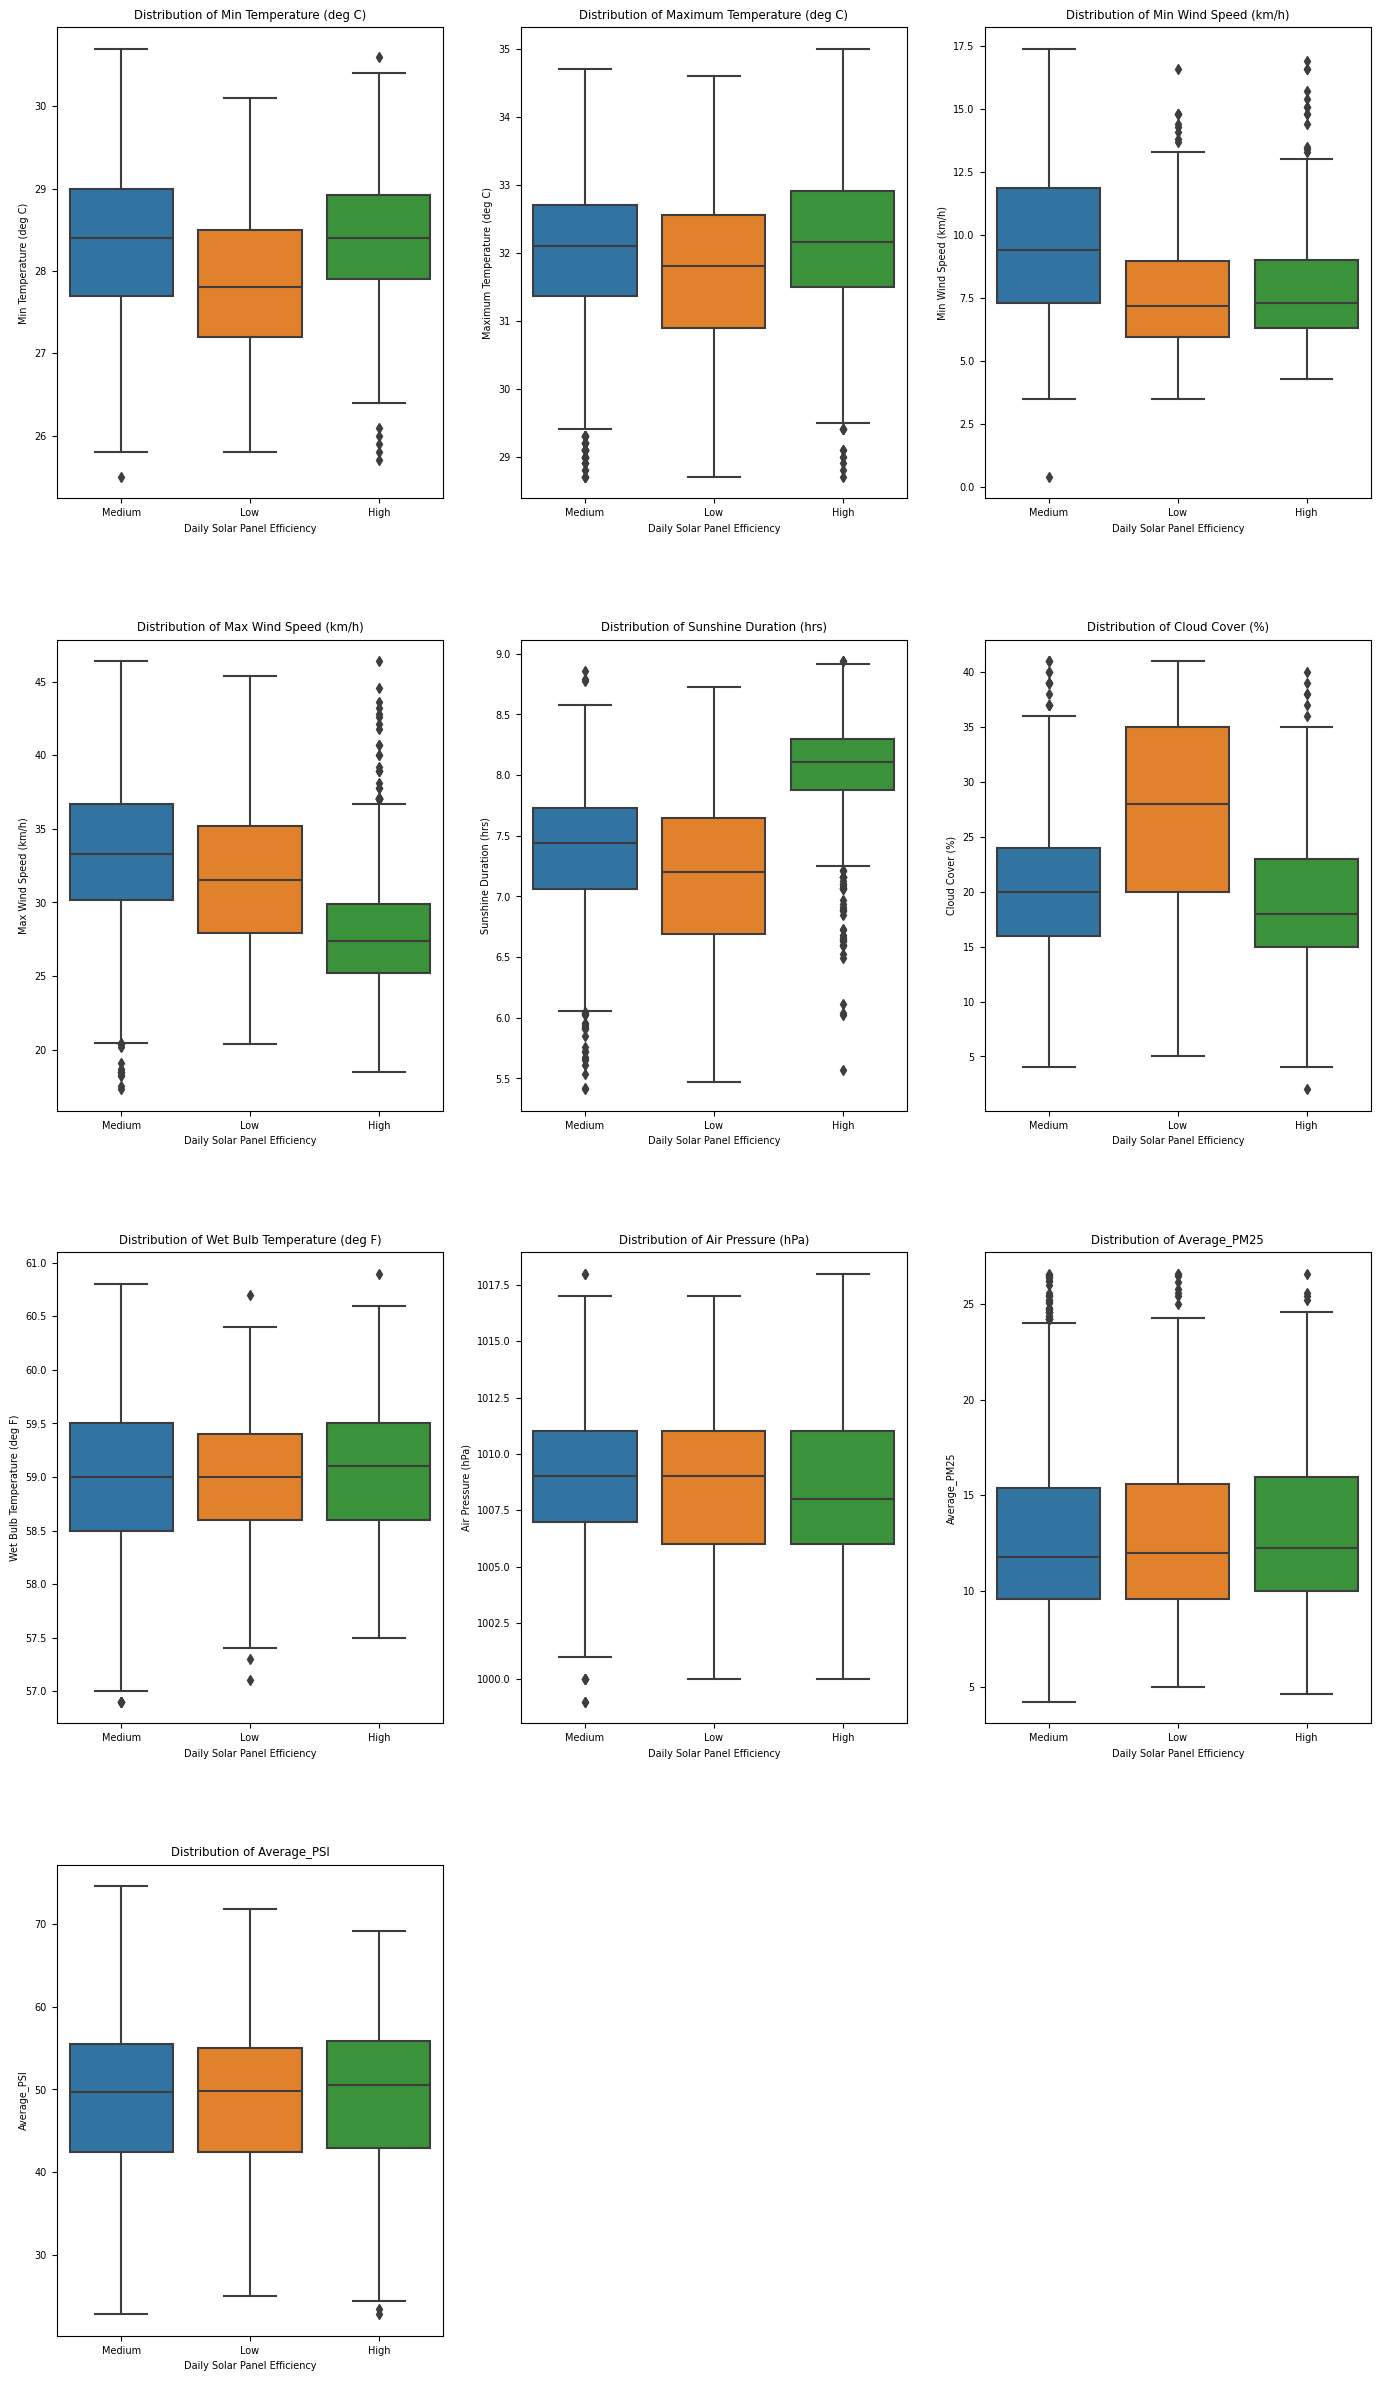

In [84]:

numeric_features = merged_data_nooutliers.select_dtypes(include=['float64', 'int64']).columns.tolist()

# Calculate the number of rows needed
num_plots = len(numeric_features)
num_rows = math.ceil(num_plots / 3)

# Create subplots
fig, axes = plt.subplots(num_rows, 3, figsize=(14, num_rows * 6))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot each numeric feature
for i, feature in enumerate(numeric_features):
    sns.boxplot(y=feature, x='Daily Solar Panel Efficiency', data=merged_data_nooutliers, ax=axes[i])
    axes[i].set_title(f'Distribution of {feature}')

# Remove any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout for better spacing
plt.tight_layout(pad=2.0)
plt.subplots_adjust(hspace=0.3, wspace=0.2)

### Looking at the target varible as a function of the various numeric variables, *Sunshine hours* seems to possitively repdict HIGH effeciency, while *cloud cover* predicts LOW efficiency. Maximum wind speed also seems to lower the effeciency.

**Target variable as a function of categorical variables**:

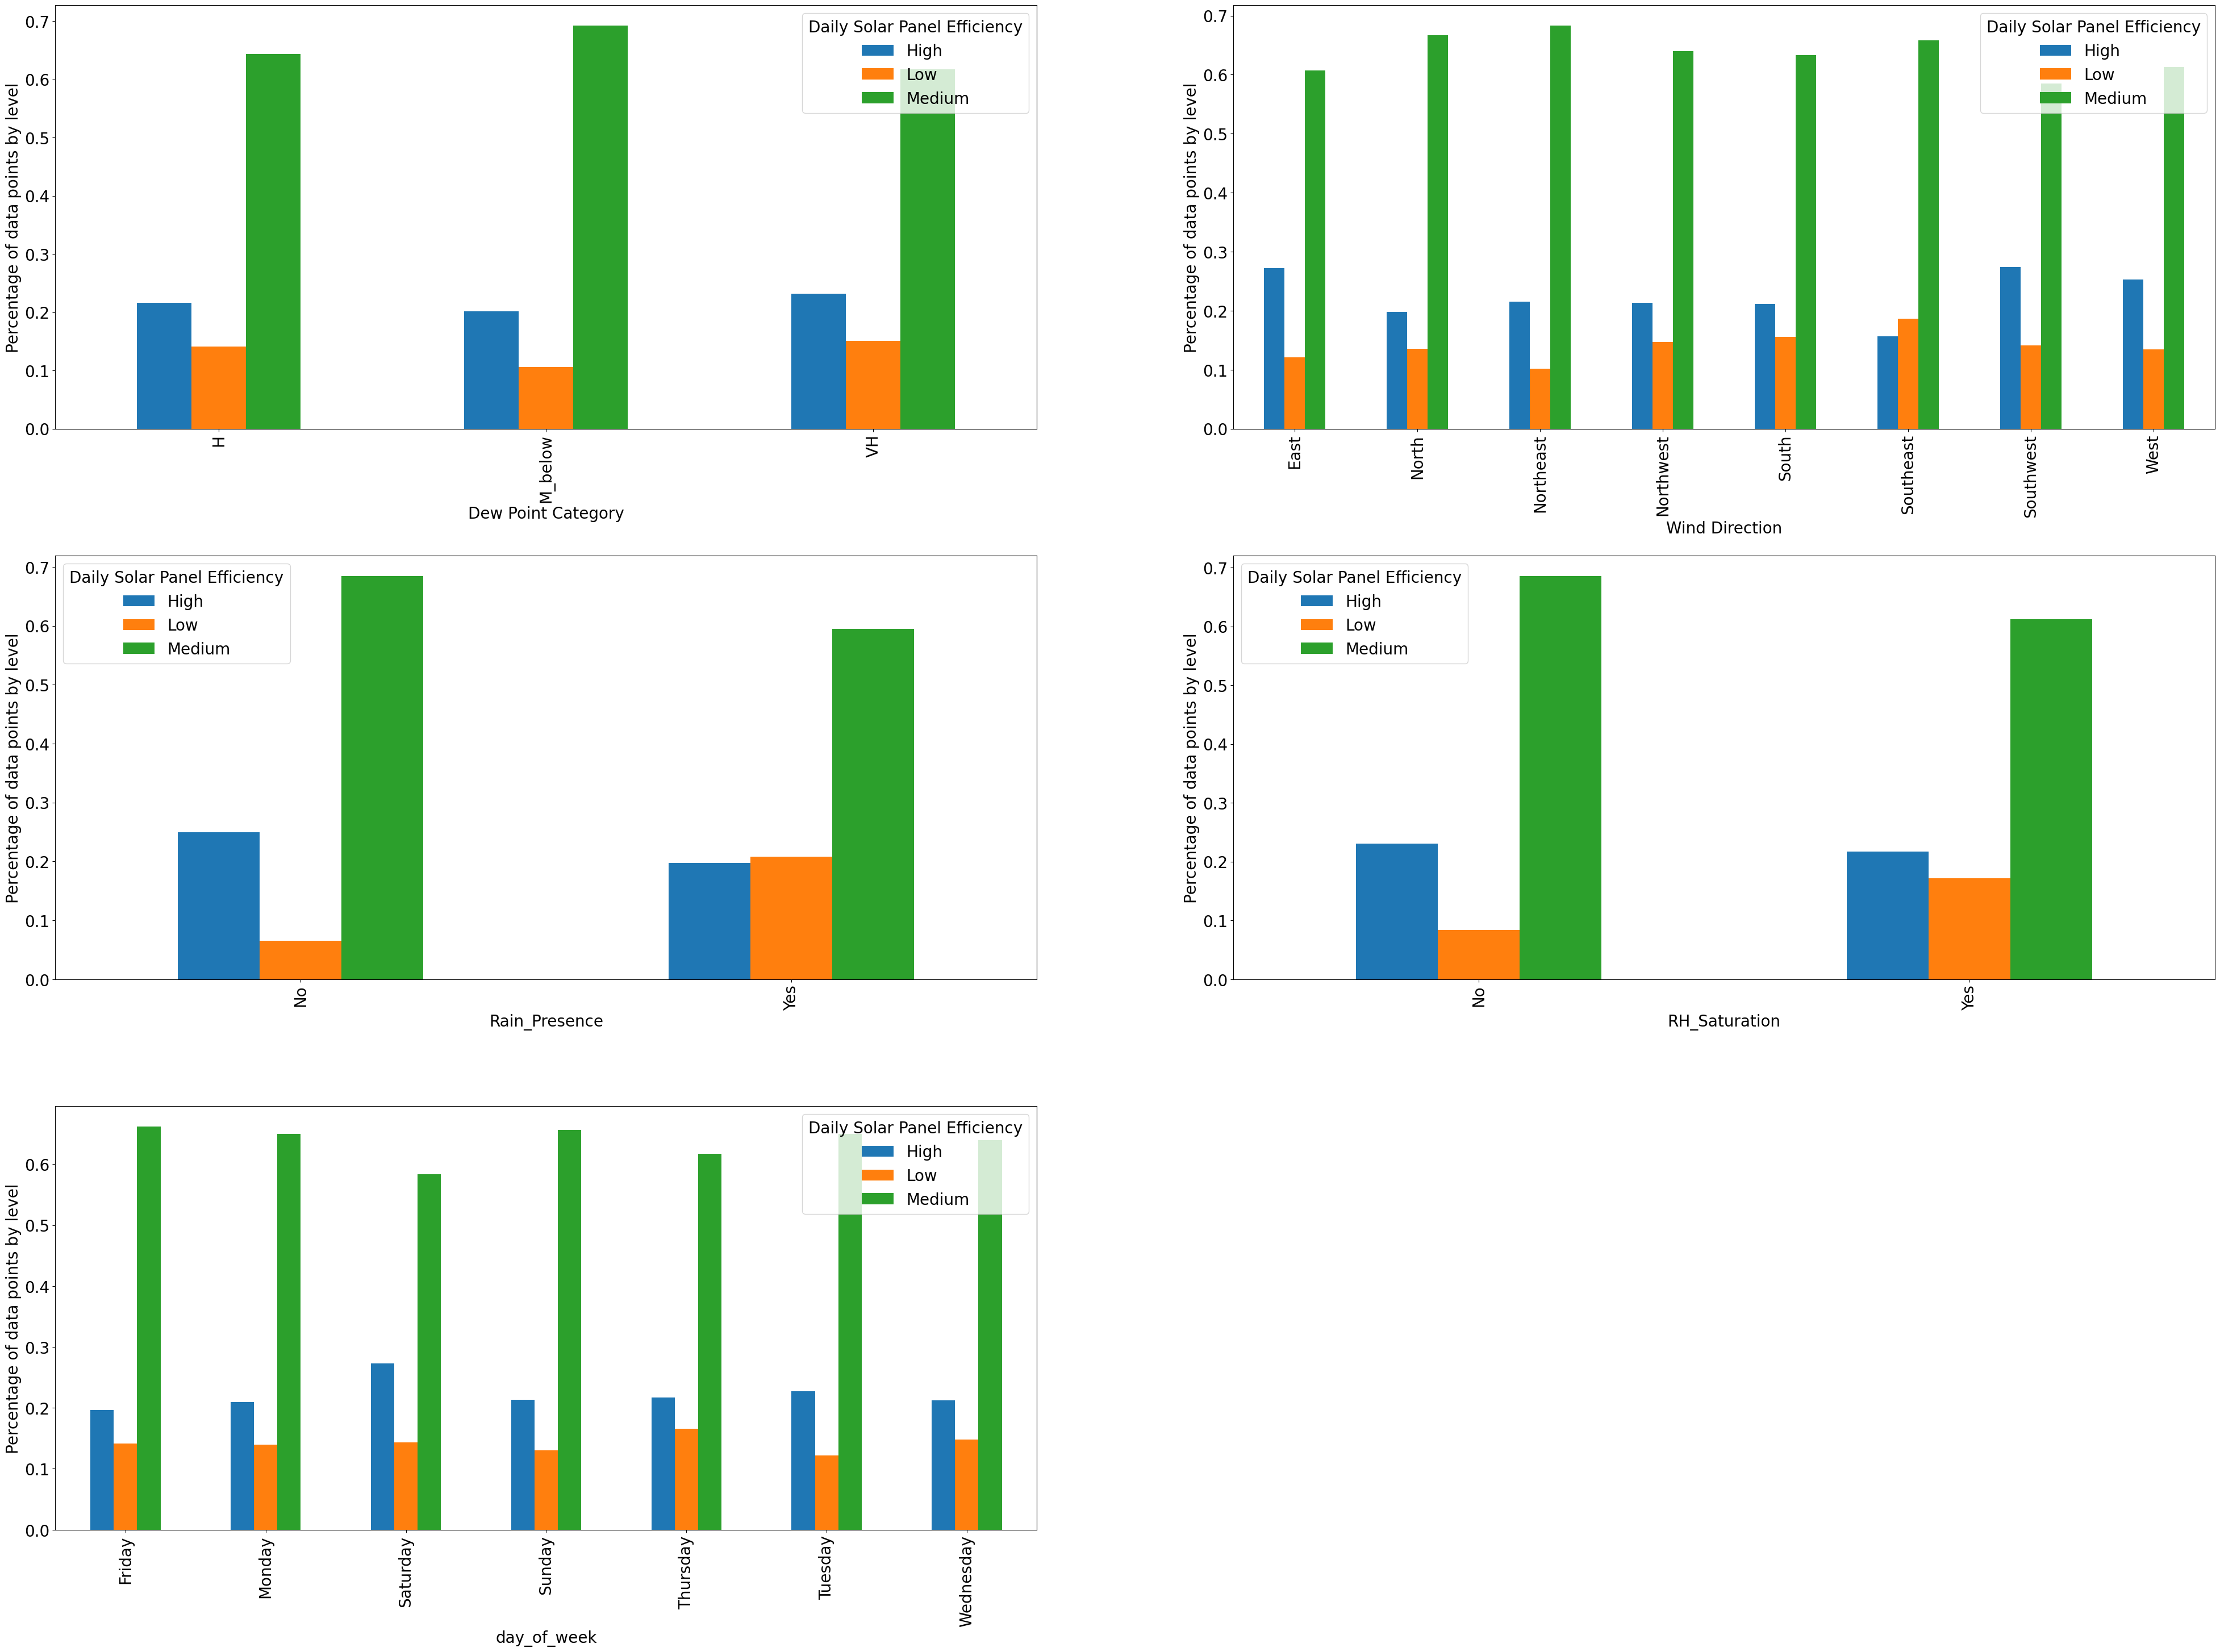

In [85]:
ix = 1
fig = plt.figure(figsize = (40,30))
plt.rcParams.update({'font.size': 20})

categorical_features = merged_data_nooutliers.select_dtypes(include=["object","category"])

# Clustered Bar Chart
for c in list(categorical_features.columns):
        if c != 'Daily Solar Panel Efficiency':
            ax1 = fig.add_subplot(3,2,ix)
            plt.tight_layout()
            #categorical_features.groupby(c).size().plot(kind='bar',ax=ax1)
            var=c
            pd.crosstab([merged_data_nooutliers[var]], merged_data_nooutliers['Daily Solar Panel Efficiency'], normalize='index').plot.bar(ax=ax1)
            plt.ylabel('Percentage of data points by level')
            ix = ix +1

# Adjust layout for better spacing
plt.tight_layout(pad=2.0)
plt.subplots_adjust(hspace=0.3, wspace=0.2)


### An apparent observation is that Efficiency is lower on days with Rainfall versus without.

### Finally, we can fit a simple Decision Tree (Random Forest) model to examine some feature importance matrices. For this we will use the upsampled dataset (merged_upsampled):

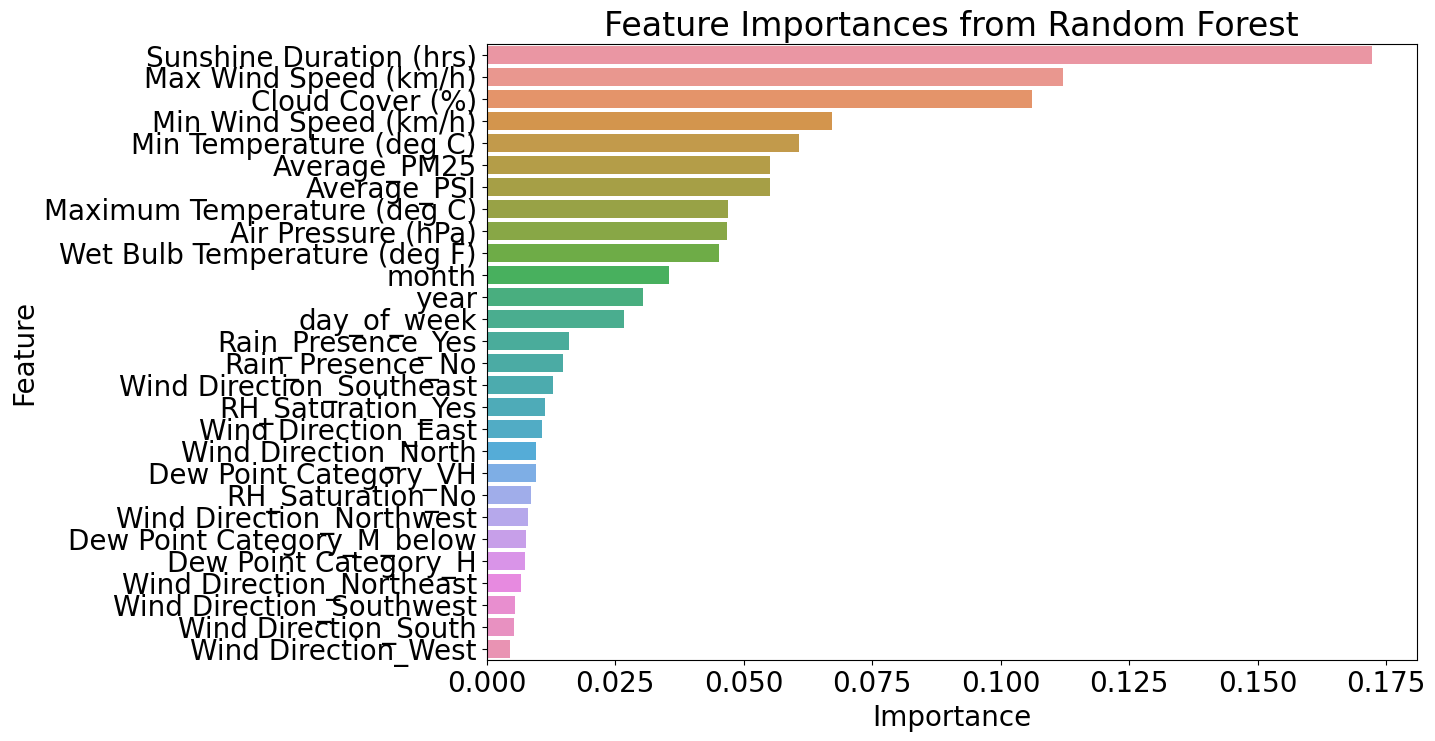

In [92]:
df = merged_upsampled
# Define the features and target
X = df.drop(columns=['Daily Solar Panel Efficiency'])
y = df['Daily Solar Panel Efficiency']

# Identify categorical and numerical features
categorical_features_ohe = ['Wind Direction', 'Rain_Presence', 'RH_Saturation', 'Dew Point Category']  # List of features for OneHotEncoder
categorical_features_le = ['day_of_week','month','year']  # List of features for LabelEncoder
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Apply Label Encoding to the specified features
le = LabelEncoder()
for col in categorical_features_le:
    X[col] = le.fit_transform(X[col])

# Define the preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat_ohe', OneHotEncoder(), categorical_features_ohe)])

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Apply the preprocessor to the training data
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

# Combine transformed features with label encoded features
X_train_combined = np.hstack((X_train_transformed, X_train[categorical_features_le].values))
X_test_combined = np.hstack((X_test_transformed, X_test[categorical_features_le].values))

# Train a Random Forest model
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_combined, y_train)

# Get feature names after encoding
encoded_feature_names = numerical_features + \
    list(preprocessor.named_transformers_['cat_ohe'].get_feature_names_out(categorical_features_ohe)) + \
    categorical_features_le

# Get feature importances
importances = rf.feature_importances_
feature_importances = pd.DataFrame({'feature': encoded_feature_names, 'importance': importances})

# Sort by importance
feature_importances = feature_importances.sort_values(by='importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=feature_importances)
plt.title('Feature Importances from Random Forest')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()


# Final remarks on EDA
### Outlier Detection and Removal: Using the Inter Quartile Range (IQR) method, we successfully identified and removed outliers. This step was crucial as it helped in mitigating the impact of extreme values, which can distort model training and evaluation.

### Handling Categorical Variables: Both OneHotEncoder and LabelEncoder were employed to handle categorical variables appropriately. This ensured that the categorical features were transformed into a format suitable for machine learning models without losing important information.

### Feature Importance Analysis: A Random Forest classifier was trained on the dataset to determine the importance of each feature. The feature importance analysis revealed that Sunshine duration, Max/Min Wind Speed, Cloud Cover has most significant impact on the target variable, guiding future feature selection and engineering efforts.